#                                      Image Description using AI

### Importing necessary libraries



In [1]:
## Import all important libraries
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import ResNet50, imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization, Input, \
                                    LSTM, Embedding, Input, TimeDistributed, Bidirectional, Activation, RepeatVector, Concatenate
from keras.preprocessing.sequence import pad_sequences


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import cv2
import os
%matplotlib inline

In [2]:
#Loading image files
import zipfile as zf
files = zf.ZipFile("images.zip", 'r')
files.extractall('directory to extract')
files.close()

In [3]:
## Read the file
df = pd.read_csv('dataset1.csv',encoding='cp1252')
df.head()

,Title,Description,Material,Pattern,Neckline,Image_Path
0,Peach Poly Crepe jumpsuit,This stylish foil print kurta from janasya is ...,Crepe,Printed,Round Neck,/images/pic_0.jpg
1,Light Brown Bias Yoke Checks Top,This check pattern top by Work Label is crafte...,Cotton,Checks,Round Neck,/images/pic_1.jpg
2,Off White Geometric Straight Cotton Dobby Top ...,"Featuring elegant printed details, this off wh...",Viscose,Checks,Round Neck,/images/pic_2.jpg
3,Blue Me Away Cape Top,Add an extra dose of style to your casual ward...,Polyester,Solid/Plain,V-Neck,/images/pic_3.jpg
4,Yellow On A High Gown,Yellow polyester georgette maxi dress. Polyest...,Polyester,Solid/Plain,V-Neck,/images/pic_4.jpg


In [4]:
path = list(df['Image_Path'])
Iamge_Description = list(df["Description"])

### Image Preprocessing

In [5]:
## Edit the image path 
imagePath = []
for i in path:
  ip =  "directory to extract"+i
  imagePath.append(ip)

**Resize images**

In [6]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()
def processing(data):
    # loading image
    # Getting 3 images to work with 
    img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in data[:]]
    
    print('Original size',img[0].shape)
    # --------------------------------
    # setting dim of the resize
    height = 224
    width = 224
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
       
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    print("RESIZED", res_img[1].shape)
    
    # Visualizing one of the images in the array
    original = res_img[1]
    display_one(original)

Original size (2000, 1500, 3)
RESIZED (224, 224, 3)


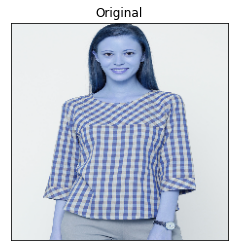

In [7]:
processing(imagePath)

**Remove noise(Denoise)**

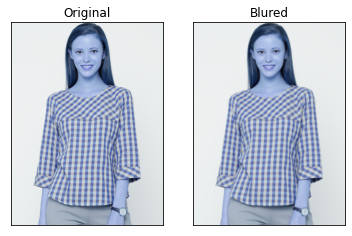

In [8]:
no_noise = []
for i in range(len(imagePath)):
    src=cv2.imread(imagePath[i],cv2.IMREAD_UNCHANGED)
    
    blur = cv2.GaussianBlur(src, (15,15), 0)
    no_noise.append(blur)


image = no_noise[1]

s=cv2.imread(imagePath[1],cv2.IMREAD_UNCHANGED)
display(s,image,'Original','Blured')



## **Preprocessing of Descriptions**

In [9]:
# Add Imagepath and Description in one dictionary i.e., Key as Image path and values as description
dataa = {}
for i, j in zip(imagePath, Iamge_Description):
  dataa[i] = j

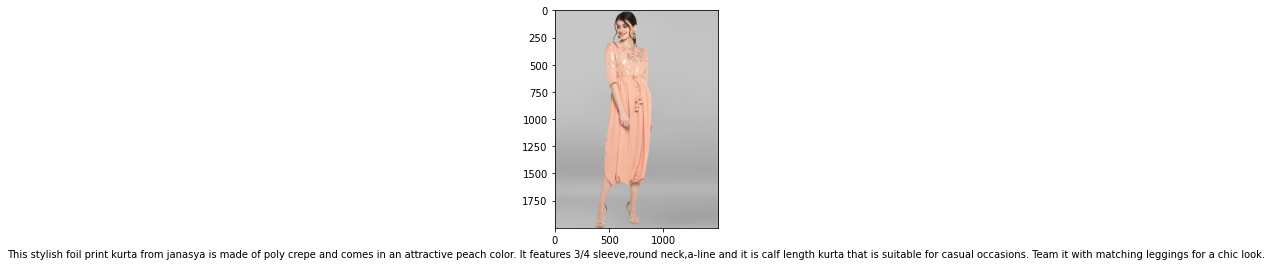

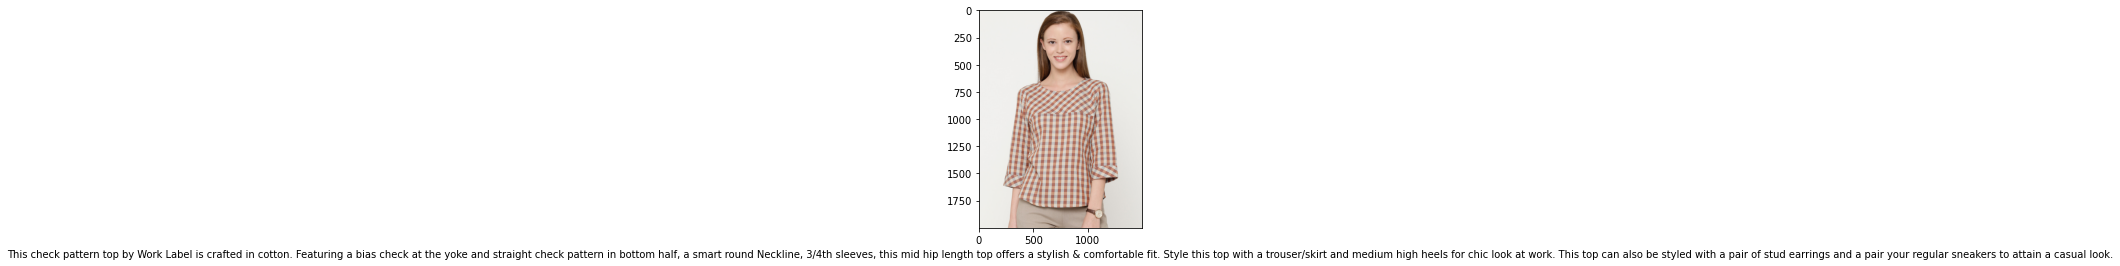

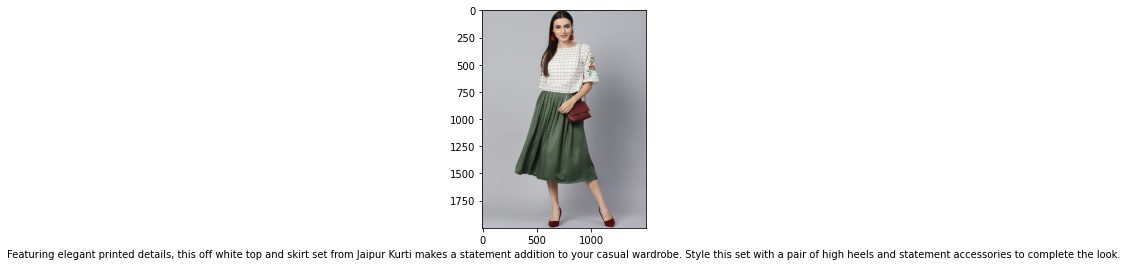

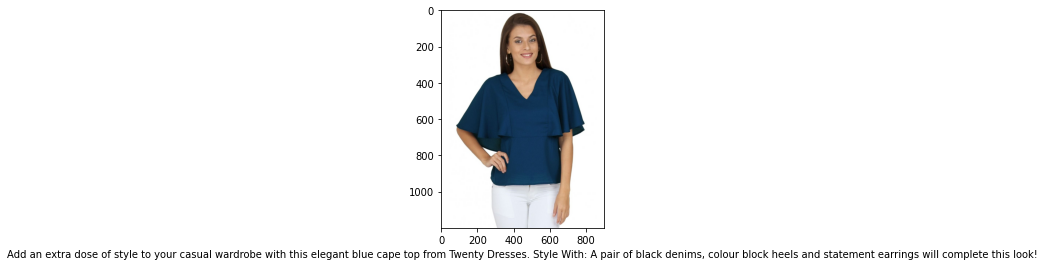

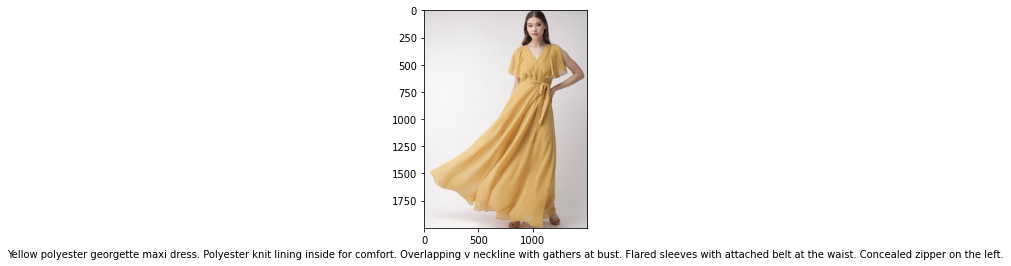

In [10]:
for i in range(5):
  plt.figure()
  img_name = imagePath[i]
  
  
  img = cv2.imread(img_name)
  
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.xlabel(dataa[img_name])
  plt.imshow(img)


In [11]:
## Preprocess the description
def preprocessed(txt):
    modified = txt.lower()
    ## Add start and end element in description
    modified = 'startofseq ' + modified + ' endofseq'   
    return modified

In [12]:
## Apply the preprocessing on our dict
for k,v in dataa.items():
      dataa[k] = preprocessed(str(v))

In [13]:
## After preprocessing
dataa['directory to extract/images/pic_199.jpg']

'startofseq olive polyester crepe dress. wrap style v neckline with three fourth sleeves. button detail on the left thigh. elasticated waist with an attached tie up belt. ruching on the sleeve sides with tie up detailing. fit and flare silhouette. endofseq'

###  Generate the Vocabulary

In [14]:
## Create a Vocabulary or Vocabulary of dictionary
count_words = {}
for k,v in dataa.items():
  
  for word in v.split():
    if word not in count_words:

      count_words[word] = 0

    else:
      count_words[word] += 1

In [15]:
## Total words present
len(count_words)

1948

In [16]:
## concert a caption dict in the interger words i.e., machine understandable form
## Key as imagePath and description converted to integers
for k, v in dataa.items():
   
  encoded = []
  for word in v.split():  
    encoded.append(count_words[word])

  dataa[k] = encoded

In [17]:
dataa['directory to extract/images/pic_199.jpg']

[499,
 5,
 119,
 45,
 46,
 23,
 231,
 40,
 59,
 712,
 14,
 12,
 34,
 44,
 19,
 136,
 472,
 14,
 0,
 24,
 56,
 712,
 80,
 8,
 26,
 48,
 4,
 6,
 136,
 472,
 15,
 5,
 712,
 26,
 48,
 9,
 54,
 919,
 34,
 40,
 499]

### Using Transfer Learning technique for generation of image features

Popular Transfer Learning techniques are mentioned below

1.VGG (e.g. VGG16 or VGG19)

2.GoogLeNet (e.g. InceptionV3)

3.Residual Network (e.g. ResNet50)

Out of these the Residual Network, or ResNet for short, is a model that makes use of the residual module involving shortcut connections.
Let us load the model

In [18]:
## Call ResNet model
ResNet = ResNet50(include_top=True)

In [19]:
## Apply ResNet model on all images
last = ResNet.layers[-2].output
modell = Model(inputs = ResNet.input,outputs = last)
modell.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [20]:
## Lets predict using ResNet model and add it in a dictionary
images_features = {}
count = 0
for i in imagePath:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modell.predict(img).reshape(2048,)
        
    # img_name = i.split('/')[-1]
    
    images_features[i] = pred
    
    count += 1
    
    if count > 1499:
        break
        
    elif count % 50 == 0:
        print(count)

50
100
150
200
250
300
350
400
450
500


In [22]:
 ## Values stored in image features dictionary
 images_features['directory to extract/images/pic_82.jpg']

array([1.6811159 , 2.175394  , 0.06980766, ..., 0.03872644, 1.4715194 ,
       0.19152334], dtype=float32)

### Built Generator Function

**Splitting each word and setting next word to repredicted as our output.**



In [23]:
max_len = 0
for k, v in dataa.items():

  if len(v) > max_len:
    max_len = len(v)
    print(v)

[499, 562, 18, 2, 27, 7, 166, 1, 238, 25, 200, 1, 45, 919, 18, 226, 80, 1, 7, 2, 175, 128, 2, 0, 0, 919, 175, 238, 0, 14, 7, 45, 238, 1, 308, 61, 5, 35, 175, 712, 6, 4, 308, 872, 32, 167, 499]
[499, 562, 7, 6, 197, 114, 13, 5, 238, 126, 226, 0, 40, 872, 1, 7, 137, 472, 12, 919, 29, 7, 6, 226, 14, 0, 872, 7, 46, 12, 29, 56, 562, 1, 3, 14, 197, 0, 872, 18, 44, 13, 66, 231, 562, 197, 712, 872, 0, 919, 0, 80, 151, 308, 32, 37, 137, 0, 562, 197, 21, 4, 39, 4, 712, 872, 183, 200, 4, 29, 919, 872, 183, 126, 77, 19, 326, 3, 872, 61, 167, 499]
[499, 66, 63, 76, 5, 46, 26, 48, 59, 19, 712, 872, 11, 3, 30, 10, 137, 472, 69, 12, 919, 44, 13, 69, 63, 308, 51, 919, 53, 5, 1, 137, 472, 11, 308, 45, 63, 23, 10, 20, 69, 712, 872, 5, 2, 308, 472, 5, 126, 2, 23, 238, 3, 226, 308, 872, 3, 19, 45, 238, 872, 3, 200, 9, 16, 44, 45, 10, 36, 28, 151, 872, 12, 24, 919, 7, 16, 57, 9, 49, 7, 7, 226, 2, 1, 499]
[499, 562, 66, 63, 76, 214, 114, 2, 238, 126, 226, 45, 919, 128, 872, 22, 66, 0, 59, 12, 52, 0, 118, 166

In [24]:
## Maximum length array
max_len

88

In [25]:
## Generate a X, y_in and y_out taking photo dict(i.e., contain ResNet prediction) and caption dict(i.e., contain description in integer)
VOCAB_SIZE = len(count_words)

def generator(photo, caption):
    
  X = []
  y_in = []
  y_out = []
  
  for k, v in caption.items():
    
    for i in range(1, len(v)):
      X.append(photo[k])         ## Appending image featurees to X var

      in_seq= [v[:i]]            ## splitting the description in a sequence i.e., 0-1, 0-1-2, 0-1-2-3, ........... 
      out_seq = v[i]             ## Next word

      ## use pad sequence to convert the variable length to max_len i.e., 88
      in_seq = pad_sequences(in_seq, maxlen=max_len, padding='post', truncating='post')[0]
      out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

      y_in.append(in_seq)
      y_out.append(out_seq)
          
  return X, y_in, y_out

In [26]:
## run the generator func and add values in Variables
X, y_in, y_out = generator(images_features, dataa)

In [27]:
## length of all variables
len(X), len(y_in), len(y_out)

(18518, 18518, 18518)

In [28]:
## convert them  in array
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [29]:
## shapes
X.shape, y_in.shape, y_out.shape

((18518, 2048), (18518, 88), (18518, 1948))

In [30]:
## Built a model
embedding_size = 128
max_len = max_len
vocab_size = len(count_words)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(256, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 88, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 88, 128)           249344    
_________________________________________________________________
lstm (LSTM)                  (None, 88, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 88, 128)           32896     
Total params: 676,480
Traina

In [31]:
## plot the model
from keras.utils import plot_model
plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
## fit the model
model.fit([X, y_in], y_out, batch_size=512, epochs=100)

Epoch 1/100
37/37 [==============================] - 558s 14s/step - loss: 5.0042 - accuracy: 0.0433
Epoch 2/100
37/37 [==============================] - 1233s 34s/step - loss: 4.2833 - accuracy: 0.0453
Epoch 3/100
37/37 [==============================] - 979s 27s/step - loss: 4.2821 - accuracy: 0.0491
Epoch 4/100
37/37 [==============================] - 30317s 842s/step - loss: 4.2811 - accuracy: 0.0485
Epoch 5/100
37/37 [==============================] - 754s 20s/step - loss: 4.2564 - accuracy: 0.0536
Epoch 6/100
37/37 [==============================] - 860s 23s/step - loss: 4.2087 - accuracy: 0.0627
Epoch 7/100
37/37 [==============================] - 925s 25s/step - loss: 4.1847 - accuracy: 0.0605
Epoch 8/100
37/37 [==============================] - 1031s 28s/step - loss: 4.1532 - accuracy: 0.0638
Epoch 9/100
 8/37 [=====>........................] - ETA: 13:10 - loss: 4.1537 - accuracy: 0.0658

In [40]:
## Inverse the dictionary
inv_dict = {v:k for k, v in count_words.items()}

In [45]:
## save the model
model.save('image_desc.h5')

### Predictions

In [69]:
## function to convert the image in machine readable format
def getImage(x):
  
  # test_img_path = imagePath[x]

  test_img = cv2.imread(x)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

  test_img = cv2.resize(test_img, (224,224))

  test_img = np.reshape(test_img, (1,224,224,3))
  
  return test_img

In [70]:
test_feature = modell.predict(getImage('newimg2.jpg')).reshape(1,2048)

In [71]:
text_inp = ['startofseq']

count = 0
desc = ''
while count < 25:
  count += 1

  encoded = []
  for i in text_inp:
    encoded.append(count_words[i])

  encoded = [encoded]

  encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len)


  prediction = np.argmax(model.predict([test_feature, encoded]))             ## Returns a highest prob word
 
  sampled_word = inv_dict[prediction]

  desc = desc + ' ' + sampled_word
      
  if sampled_word == 'endofseq':
    break

  text_inp.append(sampled_word)

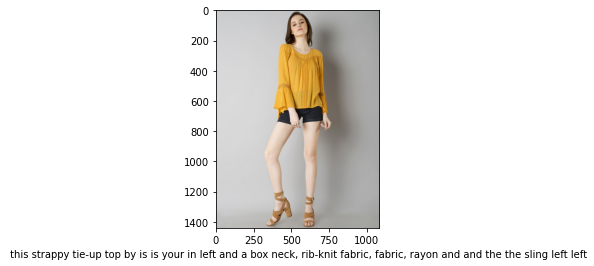

In [73]:
imag = cv2.imread('newimg2.jpg')
imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
plt.imshow(imag)
plt.xlabel(desc);

### Predict the decription of dataset images

In [ ]:
## function to convert the image in machine readable format
def getImage(x):
  
  test_img_path = imagePath[x]

  test_img = cv2.imread(test_img_path)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

  test_img = cv2.resize(test_img, (224,224))

  test_img = np.reshape(test_img, (1,224,224,3))
  
  return test_img

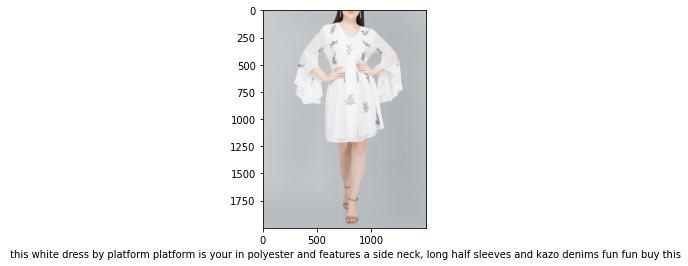

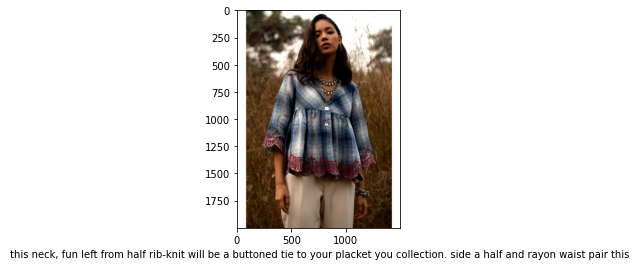

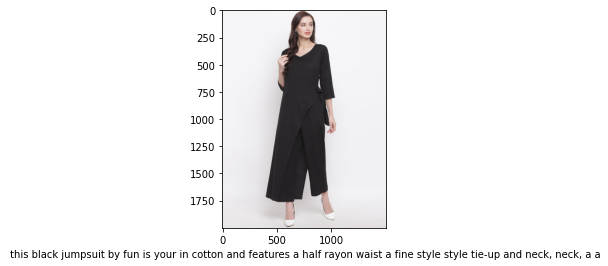

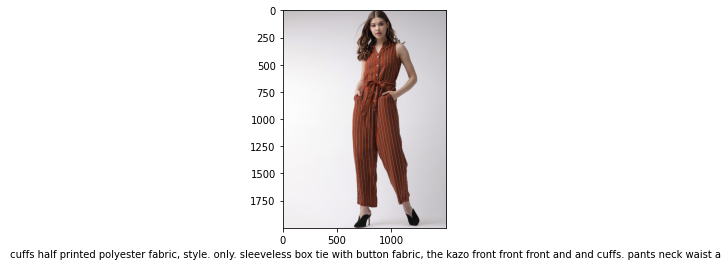

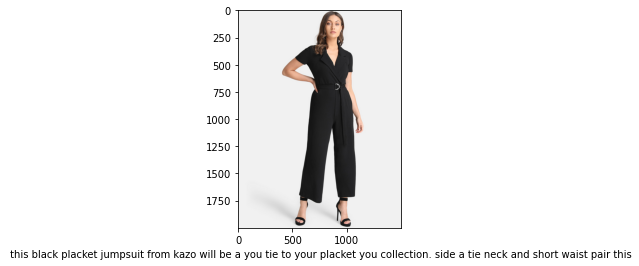

In [44]:
for i in range(5):
  
  no = np.random.randint(100,500,(1,1))[0,0]
  test_feature = modell.predict(getImage(no)).reshape(1,2048)
  
  test_img_path = imagePath[no]
  test_img = cv2.imread(test_img_path)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


  text_inp = ['startofseq']

  count = 0
  desc = ''
  while count < 25:
    count += 1

    encoded = []
    for i in text_inp:
      encoded.append(count_words[i])

    encoded = [encoded]

    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len)


    prediction = np.argmax(model.predict([test_feature, encoded]))

    sampled_word = inv_dict[prediction]

    desc = desc + ' ' + sampled_word
        
    if sampled_word == 'endofseq':
      break

    text_inp.append(sampled_word)
      
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(desc)